In [1]:
# "Basic" py library
import string
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Stats 
from mlxtend.evaluate import permutation_test
from scipy.stats import spearmanr

# visualisation
from matplotlib import pyplot as plt # basic visualisation in py
import seaborn as sns # great to interact with dataframes
import plotly.express as px # powerfull for interactive figures
from tqdm import tqdm  # generats progress bar to controll steps

from SA_utils import *

In [2]:
# Set visual style
sns.set("talk")
sns.set_style("whitegrid")

#  set the rabdom seed
seed = 31
set_seed(seed)

In [3]:
# Get punctuation and English stop-words
punct         = string.punctuation 
en_stop_words = stopwords.words('english')

# Table of Content

click on the titles to reach the described sections

---------
[Load Data](#data)

[Report Sentiment](reportsentiment)

[Emotion Alignment](EmotionAlignment)

## Load Data<a id='data'></a>

In [4]:
# Load the dataset in CSV (if already has BERT–Large emb. and PCA/t-SNE coordinates)
dream_records = pd.read_csv(
    "Dream_Reports_with-distilbert-base-uncased-finetuned-sst-2-english_predictions.csv"
)

dream_records_DE1 = dream_records[dream_records["# Dreamer Emotions"].isin([1])]
COLLECTION_order = [
    "Bea 1: a high school student", "Ed: dreams of his late wife", "Emma: 48 years of dreams",
    "Hall/VdC Norms: Female", "Hall/VdC Norms: Male", "Barb Sanders: baseline"
]

EMOTION_order    = ["Anger", "Apprehension", "Sadness", "Confusion", "Happiness"]

## Report Sentiment<a id='reportsentiment'></a>

In [5]:
Emotion_to_Score = {
    "AN": -1,
    "AP": -1,
    "SD": -1,
    "CO": 0,
    "HA": 1,
}

In [6]:
# Collect subset of predictions and run the correlation-analysis

DRlbl_SAlbl_g = get_general_sentiment(dream_records, Emotion_to_Score, emotions="General")
DRlbl_SAlbl_g["Emotions Set"] = ["General"] * len(DRlbl_SAlbl_g)

DRlbl_SAlbl_d = get_general_sentiment(dream_records, Emotion_to_Score, emotions="Dreamer")
DRlbl_SAlbl_d["Emotions Set"] = ["Dreamer"] * len(DRlbl_SAlbl_d)

DRlbl_SAlbl = pd.concat([DRlbl_SAlbl_d, DRlbl_SAlbl_g])

Gen_sent_df = []
for emotion_set in ["Dreamer", "General"]:
    for collection in tqdm(set(dream_records["collection"])):
        l_DRlbl_SAlbl = DRlbl_SAlbl[
            DRlbl_SAlbl["collection"].isin([collection]) & 
            DRlbl_SAlbl["Emotions Set"].isin([emotion_set])
        ]
        rho, p = spearmanr(l_DRlbl_SAlbl["General Sentiment"],l_DRlbl_SAlbl["Predicted Sentiment"])
        Gen_sent_df.append([rho, p, collection, emotion_set])

Gen_sent_df = pd.DataFrame(Gen_sent_df, columns=[r"Spearman $\rho$", "p", "Collection", "Emotions Set"])

d_rho, d_p = spearmanr(DRlbl_SAlbl_d["General Sentiment"],DRlbl_SAlbl_d["Predicted Sentiment"])
g_rho, g_p = spearmanr(DRlbl_SAlbl_g["General Sentiment"],DRlbl_SAlbl_g["Predicted Sentiment"])

G_DF = pd.DataFrame([["Dreamer",d_rho], ["General",g_rho]], columns=["Emotions", r"Spearman $\rho$"])


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 1239.94it/s]


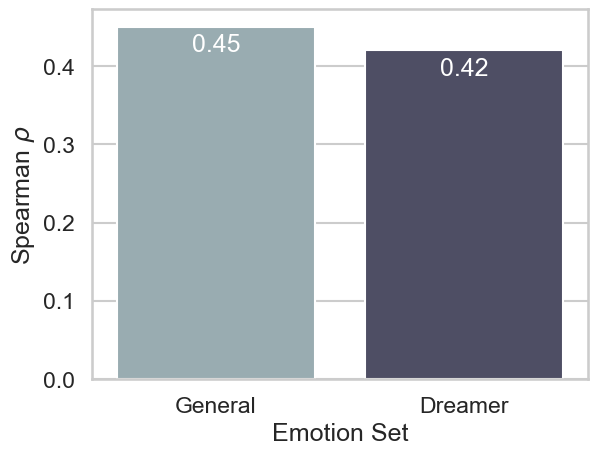

In [7]:
g = sns.barplot(
    data=G_DF, 
    y=r"Spearman $\rho$", 
    palette="bone_r", 
    x="Emotions",
    order=["General", "Dreamer"]

)

g.set_xlabel("Emotion Set")

for a in g.patches:
    g.annotate(format(a.get_height(), '.2f'),
                   (a.get_x() + a.get_width() / 2., a.get_height()),
                   ha = 'center', 
                   va = 'center',
                   xytext = (0, -13),
                   textcoords = 'offset points',
                   color="white"
              )   

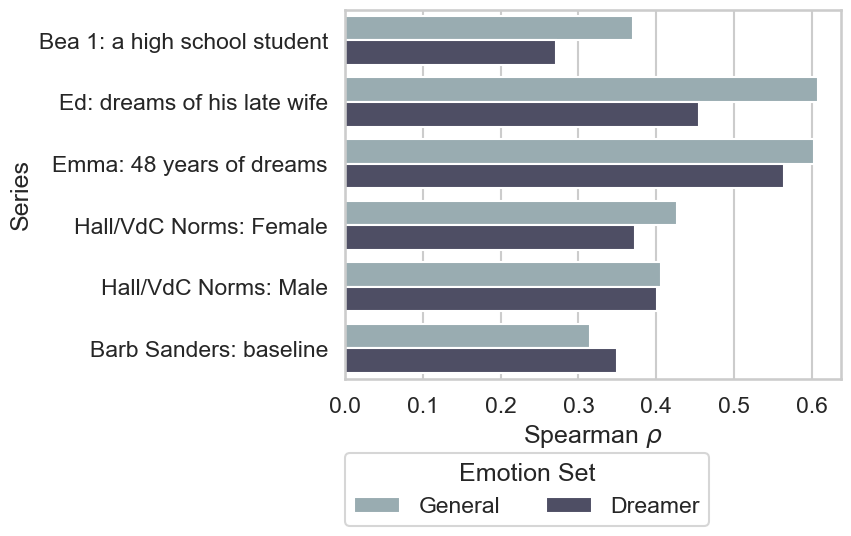

In [8]:
g = sns.barplot(
    data=Gen_sent_df, 
    x=r"Spearman $\rho$", 
    y="Collection",
    palette="bone_r", 
    order=COLLECTION_order,
    hue="Emotions Set",
    hue_order=["General", "Dreamer"]
)

g.set_ylabel("Series")
    
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(0, -.20), ncol=3, loc=2, borderaxespad=0., title="Emotion Set")

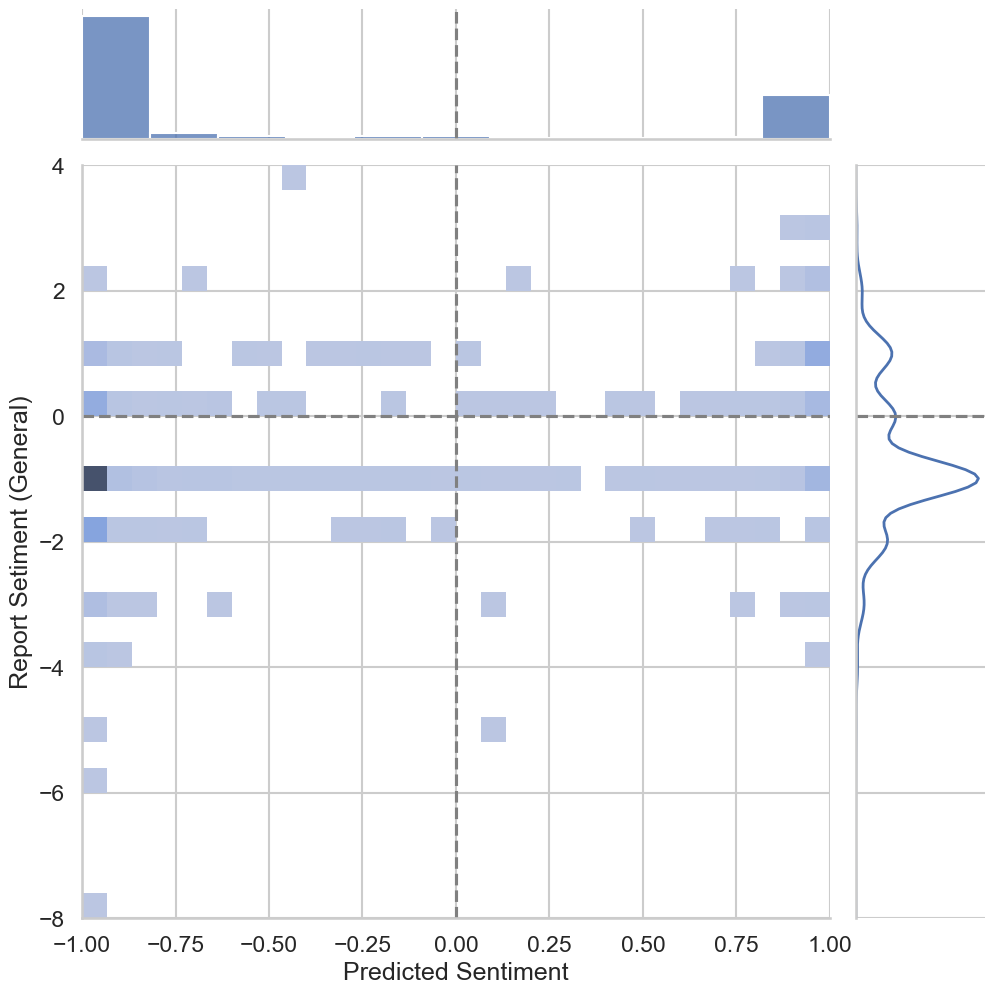

In [9]:
DATA = DRlbl_SAlbl_g
g = sns.JointGrid(height=10, xlim=(-1, 1), ylim=(-8, 4))
g1 = sns.histplot(
    data=DATA, 
    x="Predicted Sentiment", 
    y="General Sentiment", 
    ax=g.ax_joint, 
    bins=30,
)

g1.set(ylabel="Report Setiment (General)")

sns.kdeplot(data=DATA, y="General Sentiment", linewidth=2, ax=g.ax_marg_y)

sns.histplot(data=DATA, x="Predicted Sentiment", ax=g.ax_marg_x)

# set a line along 0-coordinates
g.refline(x=0, y=0)

## Emotion Alignment<a id='EmotionAlignment'></a>

In [10]:
# Collect one-emotion subset for General and Dreamer Emotion set

N_emotions = "one" # or "all"
REF_SENT   = "POSITIVE"

DRlbl_SAlbl_one_d = get_SA_scores(
                    dream_records, 
                    emotions="Dreamer", 
                    N_emotions="one", 
                    reference_Sentiment=REF_SENT,
)

DRlbl_SAlbl_one_d_df = pd.DataFrame(
    DRlbl_SAlbl_one_d, columns=[
    "Emotion", "%(l={})".format(REF_SENT), "collection"]
)

DRlbl_SAlbl_one_g = get_SA_scores(
                    dream_records, 
                    emotions="General", 
                    N_emotions="one", 
                    reference_Sentiment=REF_SENT,
)

DRlbl_SAlbl_one_g_df = pd.DataFrame(
    DRlbl_SAlbl_one_g, columns=[
    "Emotion", "%(l={})".format(REF_SENT), "collection"]
)

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 799.30it/s]


In [11]:
DRlbl_SAlbl_one_d_df["Emotion Set"] = ["Dreamer"]*len(DRlbl_SAlbl_one_d_df)
DRlbl_SAlbl_one_g_df["Emotion Set"] = ["General"]*len(DRlbl_SAlbl_one_g_df)

DRlbl_SAlbl_full_df = pd.concat([DRlbl_SAlbl_one_d_df, DRlbl_SAlbl_one_g_df])
DRlbl_SAlbl_full_df = DRlbl_SAlbl_full_df.reset_index(drop=True)

Text(-0.1, 53, 'Random')

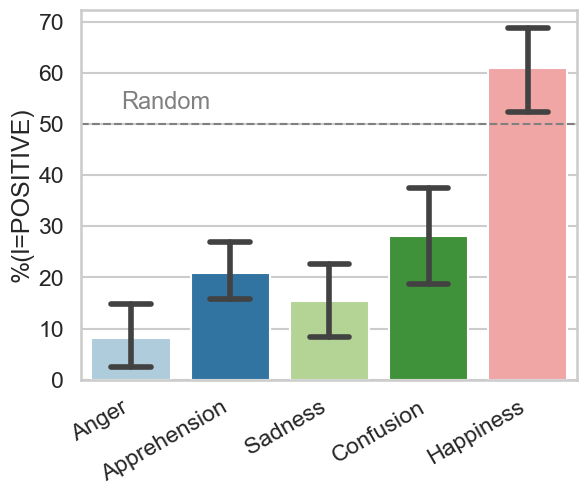

In [12]:
g = sns.barplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="%(l={})".format(REF_SENT),
    order=EMOTION_order,
    palette="Paired",
#     errorbar=("sd", 1),
    capsize=.4, 
    linewidth=1.5,
)

plt.xticks(
    rotation=30, 
    horizontalalignment='right',
)

g.set_xlabel("")
g.axhline(50, ls='--', color="gray", linewidth=1.5)
g.text(-.1, 53, "Random", color="gray", fontsize=17) 

Text(1.5, 53, 'Random')

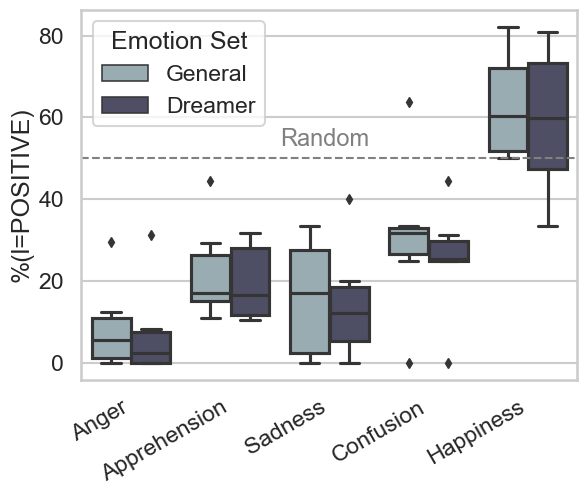

In [14]:
g = sns.boxplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="%(l={})".format(REF_SENT),
    order=EMOTION_order,
    hue="Emotion Set",
    palette="bone_r",
    hue_order=["General", "Dreamer"]
)

g.set_xlabel("")
_ = g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')
g.axhline(50, ls='--', color="gray", linewidth=1.5)
g.text(1.5, 53, "Random", color="gray", fontsize=17) 


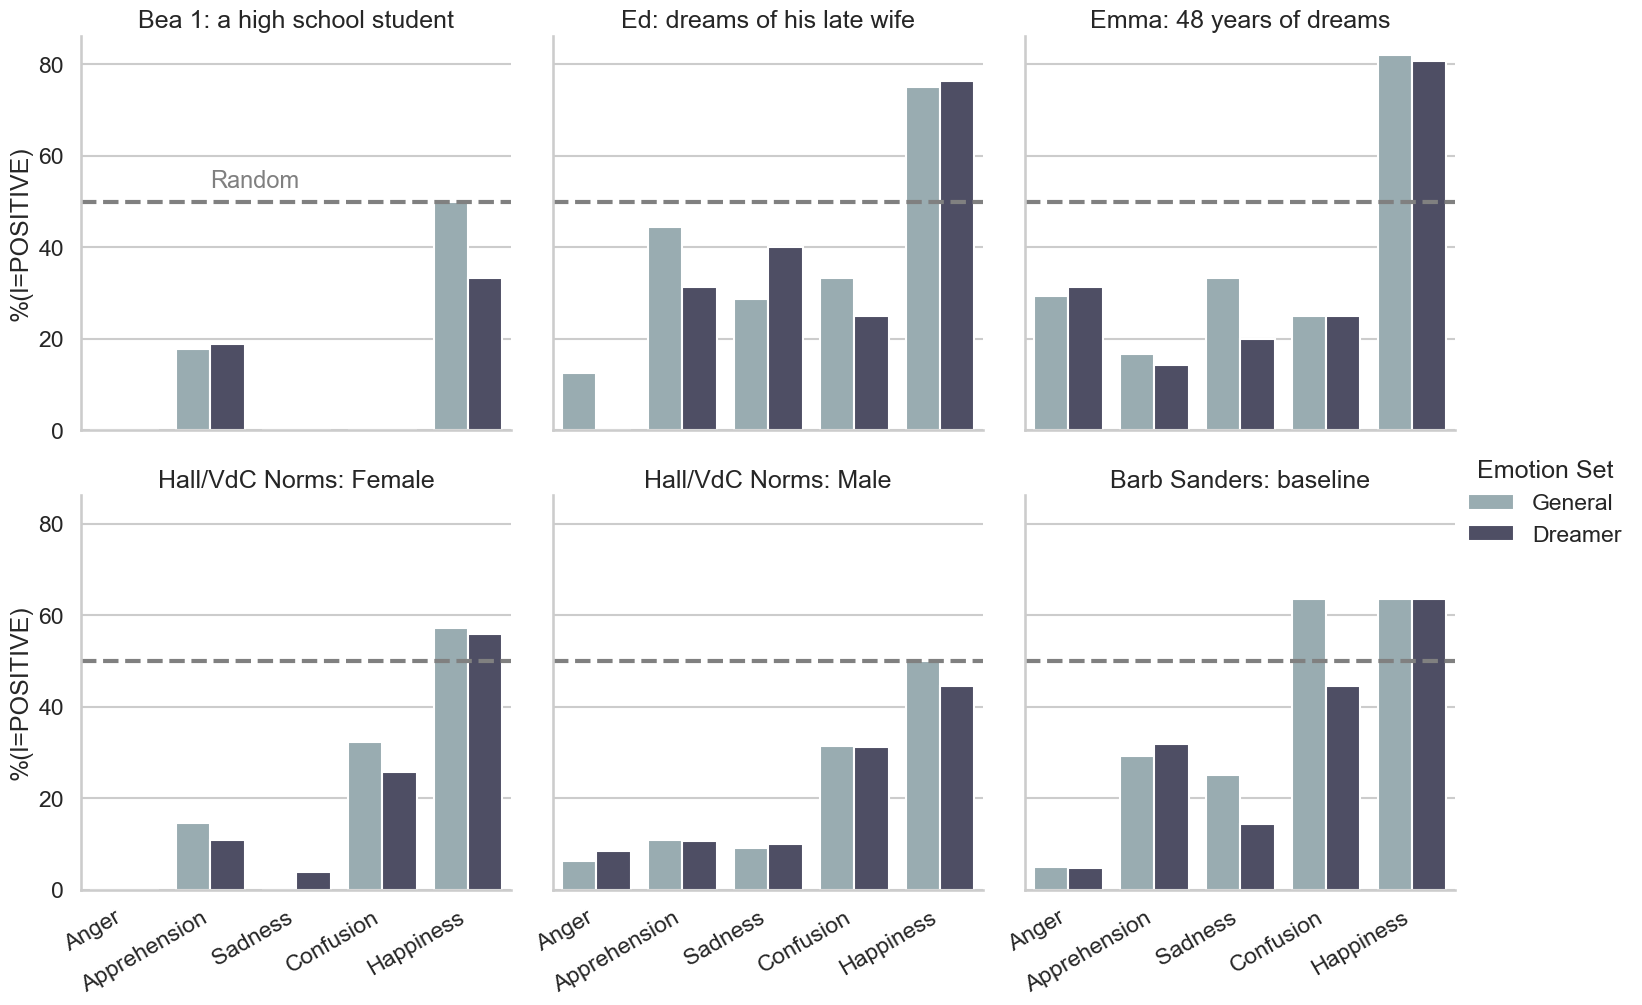

In [15]:
dk_gray, lt_gray = sns.color_palette("tab10")[7], sns.color_palette("Set2")[7]
lt_orng = sns.color_palette("Paired")[5]

g = sns.catplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="%(l={})".format(REF_SENT),
    order=EMOTION_order,
    col="collection",
    col_order=COLLECTION_order,
    col_wrap=3,
    kind="bar",
    hue="Emotion Set",
#     palette="gnuplot2_r",
    palette="bone_r",
    hue_order=["General", "Dreamer"]
#     palette=[lt_orng, lt_gray, dk_gray],
)

for cnt, axes in enumerate(g.axes.flat):
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment='right')
    axes.axhline(50, ls='--', color="gray", linewidth=3)
    axes.set_xlabel("")
    if cnt == 0:
        axes.text(1, 53, "Random", color="gray", fontsize=17) 
    
g.set_titles(template='{col_name}')